We are interested in finding the state $(z, k)$  of the nonlinear system (1.8) with no control ($u = 0$), namely:
\begin{equation}
		\left\{
		\begin{aligned}
			&h(t)\psi_{t}-\psi_{xx} - \frac{x}{2}h^{\prime}(t)\psi_{x}-h(t)\psi(1-\psi) =0 & & \text {in}\; Q, \\
			& \psi_{x}(0,t)= 0  & & \text {in}\;(0,T), \\
			& \psi(1,t)=0 & & \text {in}\;(0,T), \\
			&h^{\prime}(t)+2\mu \psi_{x}(1,t)=0 & & \text {in}\;(0,T),  \\
			& h(0)=h_{0}\\
			& \psi(\cdot,0)=\psi_{0} & &\text {in}\;(0,1),
		\end{aligned}
		\right.
	\end{equation}
	
For $h_0=0.5$ and $\psi_0=\sin(\pi x)$, 



In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Physical parameters
mu = 0.5  # Coefficient in the dynamic condition
L = 1    # Spatial domain (-1, 1)
T = 1  # Time domain (0, T)
delta = 1e-6 # to avoid singularities

In [4]:
# Neural Networks
# Network for the state z(x,t)
psi_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Network for the state k(t)
h_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((1,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])



In [5]:
# Loss function
def loss_fn():
    # sampling points
    x_sample = tf.random.uniform((1000, 1), 0, L)
    t_sample = tf.random.uniform((1000, 1), 0, T)
    xt_sample = tf.concat([x_sample, t_sample], axis=1)
    x_one_t_sample = tf.concat([tf.ones_like(t_sample), t_sample], axis=1)

    # Initial conditions
    x_init = tf.random.uniform((1000, 1), -L, L)
    psi_init_pred = psi_net(tf.concat([x_init, tf.zeros_like(x_init)], axis=1))
    def z_0(x):
        return tf.sin(np.pi * x)
    loss_init_psi = tf.reduce_mean(tf.square(psi_init_pred - z_0(x_init))) 

    t_init = tf.zeros((100, 1))
    h_init_pred = h_net(t_init)
   
    loss_init_h = tf.sqrt(tf.reduce_mean(tf.square(h_init_pred - 0.5)) + delta) # k(0)=0.5


    
    # First equation : h(t) * psi_t - psi_xx - (x / 2) * h'(t) * psi_x - h(t) * psi * (1 - psi) = 0
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xt_sample)
        psi_pred = psi_net(xt_sample)
        h_pred = h_net(t_sample)
        #u_pred = u_net(t_sample)
        psi_x = tape.gradient(psi_pred, xt_sample)[:, 0:1]
        psi_t = tape.gradient(psi_pred, xt_sample)[:, 1:2]
        psi_xx = tape.gradient(psi_x, xt_sample)[:, 0:1]

    loss_pde = tf.reduce_mean(tf.square(h_pred * psi_t - psi_xx - (x_sample / 2) * tf.gradients(h_pred, t_sample)[0] * psi_x - h_pred * psi_pred * (1 - psi_pred)))

    # Boundary conditions
    x_one_t_sample = tf.concat([tf.ones_like(t_sample), t_sample], axis=1)  # points (1, t)
    x_zero_t_sample = tf.concat([tf.zeros_like(t_sample), t_sample], axis=1)  # points (0, t)
    # Computation of \psi_x(0,t)
    with tf.GradientTape() as tape3:
      tape3.watch(x_zero_t_sample)
      psi_pred_boundary0 = psi_net(x_zero_t_sample)
      psi_x_boundary0 = tape3.gradient(psi_pred_boundary0, x_zero_t_sample)[:, 0:1]
    loss_boundary0 = tf.reduce_mean(tf.square(psi_x_boundary0))
    psi_boundary1_pred = psi_net(x_one_t_sample)
    loss_boundary1 = tf.reduce_mean(tf.square(psi_boundary1_pred))

    # Computation of \psi_x(1,t)
    with tf.GradientTape() as tape2:
      tape2.watch(x_one_t_sample)
      psi_pred_boundary = psi_net(x_one_t_sample)
      psi_x_boundary = tape2.gradient(psi_pred_boundary, x_one_t_sample)[:, 0:1]

    # Fourth equation: h^{\prime}(t)+2\mu \psi_{x}(1,t)=0
    loss_dyn_h = tf.reduce_mean(tf.square(tf.gradients(h_pred, t_sample)[0] + 2 * mu * psi_x_boundary))

    return 50 * loss_init_psi + 10 * loss_init_h +  10 * loss_boundary0 + loss_boundary1 + loss_pde + loss_dyn_h
    

In [6]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = loss_fn()
    gradients = tape.gradient(loss, psi_net.trainable_variables + h_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, psi_net.trainable_variables + h_net.trainable_variables))
    return loss

In [7]:
# Training
epochs = 20000
loss_history_train = []
for epoch in range(epochs):
    loss = train_step()
    loss_history_train.append(loss.numpy())
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")

Epoch 0: Loss = 23.385753631591797
Epoch 1000: Loss = 1.6862579584121704
Epoch 2000: Loss = 0.5917090177536011
Epoch 3000: Loss = 0.3035848140716553
Epoch 4000: Loss = 0.2708413302898407
Epoch 5000: Loss = 0.1805243045091629
Epoch 6000: Loss = 0.154581680893898
Epoch 7000: Loss = 0.1037008985877037
Epoch 8000: Loss = 0.20999765396118164
Epoch 9000: Loss = 0.10790345817804337
Epoch 10000: Loss = 0.08149880170822144
Epoch 11000: Loss = 0.06972232460975647
Epoch 12000: Loss = 0.07316502183675766
Epoch 13000: Loss = 0.046297091990709305
Epoch 14000: Loss = 0.039625879377126694
Epoch 15000: Loss = 0.04912108927965164
Epoch 16000: Loss = 0.041182465851306915
Epoch 17000: Loss = 0.06400500237941742
Epoch 18000: Loss = 0.03296806663274765
Epoch 19000: Loss = 0.04899227246642113


In [8]:
Nx, Nt = 1000, 1000  # Number of points for x ant t
x = np.linspace(0, L, Nx).reshape(-1, 1)
t = np.linspace(0, T, Nt).reshape(-1, 1)
X, T_grid = np.meshgrid(x, t)

In [9]:
# Network evaluation
xt_eval = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
psi_eval = psi_net.predict(xt_eval).reshape(Nt, Nx)
h_eval = h_net(t).numpy()

31250/31250 [==============================] - 14s 452us/step


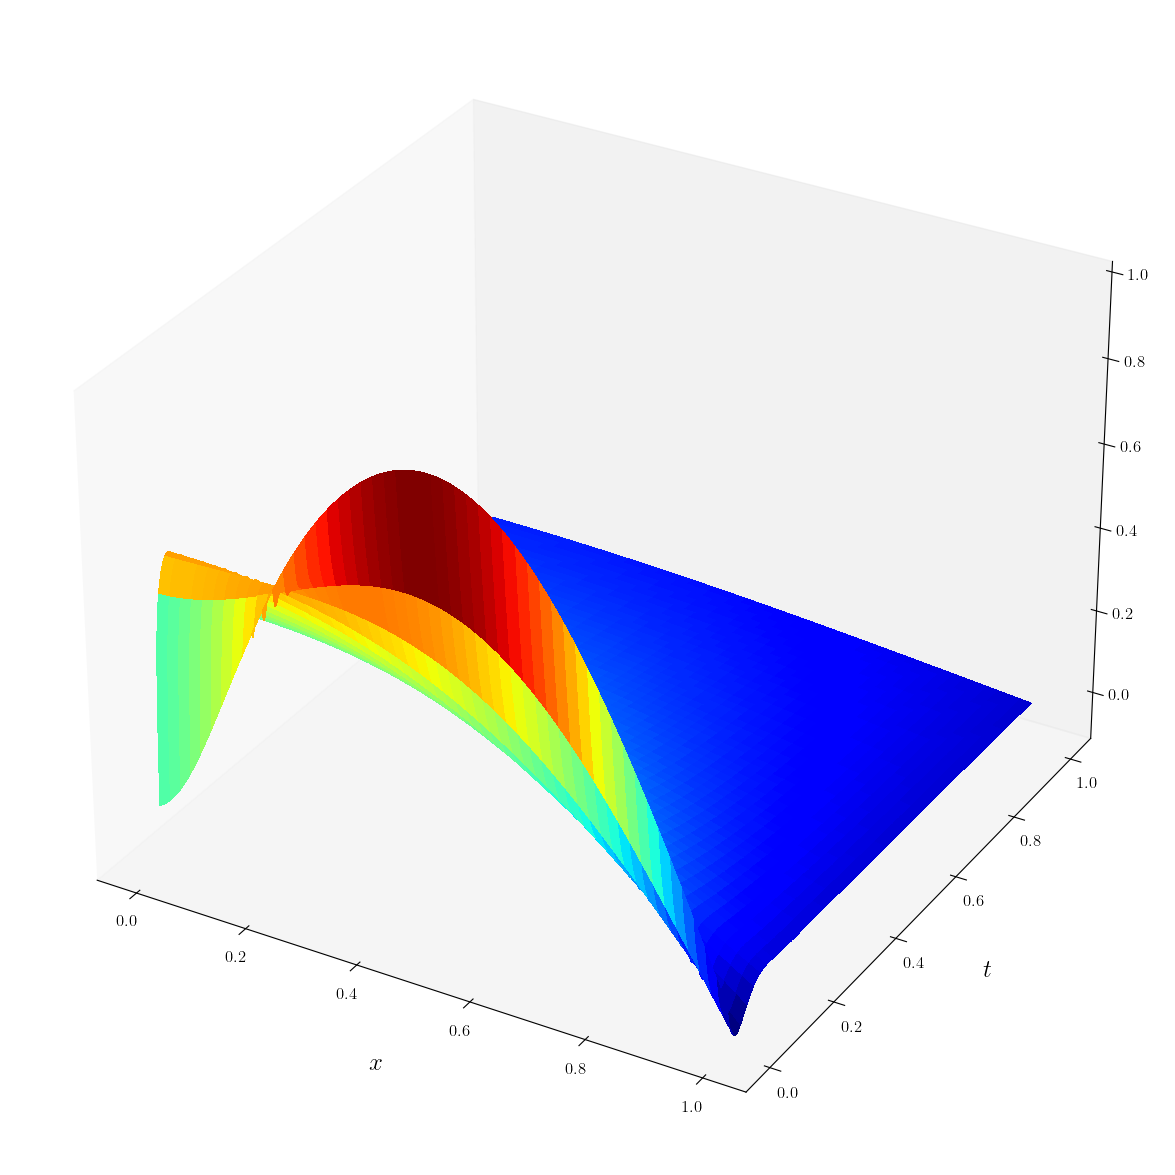

In [10]:
# Visualization
X, T_grid = np.meshgrid(x, t)
# Visualization 3D of z(x, t)
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for all text
    "font.family": "serif",  # Use serif font (default LaTeX style)
    "font.size": 12  # Adjust font size
})
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(X, T_grid, psi_eval, cmap='jet', linewidth=0, antialiased=False)
ax.grid(False)
#ax.set_title('........ z(x, t)')
#plt.legend(fontsize=14)
ax.set_xlabel('$x$', fontsize=18, color="black", labelpad=20)
ax.set_ylabel('$t$', fontsize=18, color="black", labelpad=20)
#ax.set_zlabel('State $z(x,t)$', color="black", labelpad=20)
#plt.savefig('../figures/uncontrolled_state_z_linear_n_minus_1.eps', format='eps')
plt.show()

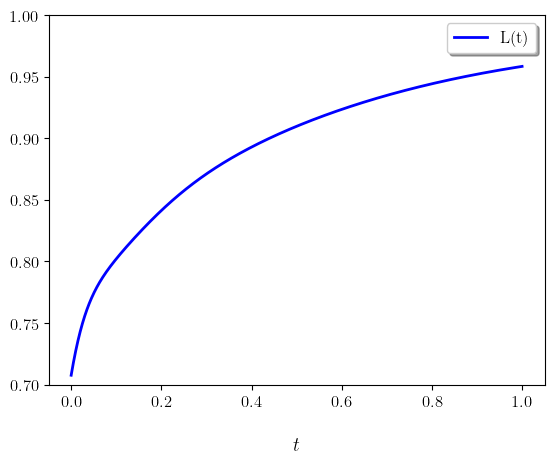

In [13]:
# Visualization 2D de k(t)
L_eval = np.sqrt(h_eval)
plt.figure()
plt.plot(t, L_eval, label=r'L(t)', linewidth=2, color='blue')
plt.xlabel(r'$t$', fontsize=14,  color="black", labelpad=20)
#plt.ylabel(r'$k(t)$', fontsize=18, color="black", labelpad=20)
#plt.title('......... k(t)')
plt.ylim(0.7, 1)
plt.legend(framealpha=1, shadow=True)
plt.savefig('../figures/nonlinear_uncontrolled.pdf', format='pdf')
plt.show()